In [ ]:
pip install pandas nltk


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download stopwords and WordNet data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the train and test datasets
train_df = pd.read_csv('/content/drive/MyDrive/FFNN WITH 2 DATASET/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FFNN WITH 2 DATASET/test.csv')  # Load test dataset

# Step 1: Check for null values in both train and test
print("Train Data Initial Shape:", train_df.shape)
print("Test Data Initial Shape:", test_df.shape)
print("Train Data Null Values:\n", train_df.isnull().sum())
print("Test Data Null Values:\n", test_df.isnull().sum())

# Step 2: Fill null values in CrimeAdditionalInfo with 'unknown' in both datasets
train_df['crimeaditionalinfo'].fillna('unknown', inplace=True)
test_df['crimeaditionalinfo'].fillna('unknown', inplace=True)

# Text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = text.split()
    # Remove stop words
    words = [word for word in words if word not in stopwords.words('english')]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply the cleaning function to the CrimeAdditionalInfo column in both datasets
train_df['CleanedCrimeInfo'] = train_df['crimeaditionalinfo'].apply(clean_text)
test_df['CleanedCrimeInfo'] = test_df['crimeaditionalinfo'].apply(clean_text)

# Display the cleaned data
print("Cleaned Train Data Sample:\n", train_df[['crimeaditionalinfo', 'CleanedCrimeInfo']].head())
print("Cleaned Test Data Sample:\n", test_df[['crimeaditionalinfo', 'CleanedCrimeInfo']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Train Data Initial Shape: (93686, 3)
Test Data Initial Shape: (31229, 3)
Train Data Null Values:
 category                 0
sub_category          6591
crimeaditionalinfo      21
dtype: int64
Test Data Null Values:
 category                 0
sub_category          2236
crimeaditionalinfo       7
dtype: int64


<ipython-input-2-ad74c9c3e5bb>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['crimeaditionalinfo'].fillna('unknown', inplace=True)
<ipython-input-2-ad74c9c3e5bb>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Cleaned Train Data Sample:
                                   crimeaditionalinfo  \
0  I had continue received random calls and abusi...   
1  The above fraudster is continuously messaging ...   
2  He is acting like a police and demanding for m...   
3  In apna Job I have applied for job interview f...   
4  I received a call from lady stating that she w...   

                                    CleanedCrimeInfo  
0  continue received random call abusive message ...  
1  fraudster continuously messaging asking pay mo...  
2  acting like police demanding money adding sect...  
3  apna job applied job interview telecalling res...  
4  received call lady stating send new phone vivo...  
Cleaned Test Data Sample:
                                   crimeaditionalinfo  \
0  Sir namaskar  mein Ranjit Kumar PatraPaise neh...   
1          KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT   
2  The issue actually started when I got this ema...   
3  I am amit kumar from karwi chitrakoot I am tot...  

In [3]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from gensim.models import FastText  # Import FastText from gensim
from sklearn.model_selection import train_test_split

# Initialize label encoders
category_encoder = LabelEncoder()
subcategory_encoder = LabelEncoder()

# Fit the encoder on both train and test data to ensure the encoder knows all labels
all_categories = np.concatenate([train_df['category'].values, test_df['category'].values])
all_subcategories = np.concatenate([train_df['sub_category'].values, test_df['sub_category'].values])

category_encoder.fit(all_categories)
subcategory_encoder.fit(all_subcategories)

# Encode categories and subcategories in both train and test data
train_df['Category_encoded'] = category_encoder.transform(train_df['category'])
train_df['Subcategory_encoded'] = subcategory_encoder.transform(train_df['sub_category'])

test_df['Category_encoded'] = category_encoder.transform(test_df['category'])
test_df['Subcategory_encoded'] = subcategory_encoder.transform(test_df['sub_category'])

# Prepare text data for FastText embedding (tokenization)
tokenized_train_text = [text.split() for text in train_df['CleanedCrimeInfo']]
tokenized_test_text = [text.split() for text in test_df['CleanedCrimeInfo']]

# Train FastText model on the combined text data (train + test) to ensure the model learns vocabulary from both datasets
fasttext_model = FastText(sentences=tokenized_train_text + tokenized_test_text, vector_size=100, window=5, min_count=1, epochs=10)

# Function to get FastText embeddings for each complaint
def get_fasttext_embeddings(text):
    tokens = text.split()
    embeddings = [fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        # Return a zero vector if no tokens are found in the FastText vocabulary
        return np.zeros(fasttext_model.vector_size)

# Apply embeddings to the dataset
train_df['Embeddings'] = train_df['CleanedCrimeInfo'].apply(get_fasttext_embeddings)
test_df['Embeddings'] = test_df['CleanedCrimeInfo'].apply(get_fasttext_embeddings)

# Prepare features and target for model training
X_train = np.stack(train_df['Embeddings'].values)
y_cat_train = train_df['Category_encoded']
y_sub_train = train_df['Subcategory_encoded']

X_test = np.stack(test_df['Embeddings'].values)
y_cat_test = test_df['Category_encoded']
y_sub_test = test_df['Subcategory_encoded']

# Split into training and validation sets from the train data
X_train, X_val, y_cat_train, y_cat_val, y_sub_train, y_sub_val = train_test_split(
    X_train, y_cat_train, y_sub_train, test_size=0.2, random_state=42
)

print("Data preparation complete. Ready for model training!")


Data preparation complete. Ready for model training!


In [4]:
 from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import pickle

# Step 4: Define the FFNN Model
input_layer = Input(shape=(X_train.shape[1],))

hidden_layer = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.4)(hidden_layer)
hidden_layer = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(hidden_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.3)(hidden_layer)
hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(hidden_layer)
hidden_layer = BatchNormalization()(hidden_layer)

# Output layers
category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(hidden_layer)
subcategory_output = Dense(len(subcategory_encoder.classes_), activation='softmax', name='subcategory_output')(hidden_layer)

# Combine inputs and outputs
model = Model(inputs=input_layer, outputs=[category_output, subcategory_output])

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'category_output': 'sparse_categorical_crossentropy',
                    'subcategory_output': 'sparse_categorical_crossentropy'},
              metrics={'category_output': 'accuracy', 'subcategory_output': 'accuracy'})

# Set early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(X_train,
                    {'category_output': y_cat_train, 'subcategory_output': y_sub_train},
                    validation_data=(X_val,
                                     {'category_output': y_cat_val, 'subcategory_output': y_sub_val}),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
results = model.evaluate(X_test,
                         {'category_output': y_cat_test,
                          'subcategory_output': y_sub_test})

# Print results for clarity
print(f"Total Loss: {results[0]:.4f}")
print(f"Category Loss: {results[1]:.4f}")
print(f"Subcategory Loss: {results[2]:.4f}")

# Safely access accuracy metrics based on the length of results
cat_acc = results[3] if len(results) > 3 else None
sub_acc = results[4] if len(results) > 4 else None

print(f"Category Accuracy: {cat_acc:.4f}" if cat_acc is not None else "Category Accuracy: Not available")
print(f"Subcategory Accuracy: {sub_acc:.4f}" if sub_acc is not None else "Subcategory Accuracy: Not available")

# Save the FFNN model
model.save("/content/drive/MyDrive/FFNN WITH 2 DATASET/ffnn_model.h5")  # Save the FFNN model

# Save the FastText model for future use
fasttext_model.save("/content/drive/MyDrive/FFNN WITH 2 DATASET/fasttext_model.bin")

# Save the encoders for future label encoding
with open('/content/drive/MyDrive/FFNN WITH 2 DATASET/category_encoder.pkl', 'wb') as f:
    pickle.dump(category_encoder, f)

with open('/content/drive/MyDrive/FFNN WITH 2 DATASET/subcategory_encoder.pkl', 'wb') as f:
    pickle.dump(subcategory_encoder, f)


Epoch 1/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - category_output_accuracy: 0.6494 - category_output_loss: 1.2465 - loss: 5.7220 - subcategory_output_accuracy: 0.4046 - subcategory_output_loss: 2.1574 - val_category_output_accuracy: 0.7445 - val_category_output_loss: 0.7593 - val_loss: 2.7351 - val_subcategory_output_accuracy: 0.4964 - val_subcategory_output_loss: 1.5990 - learning_rate: 0.0010
Epoch 2/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - category_output_accuracy: 0.7375 - category_output_loss: 0.7754 - loss: 2.7032 - subcategory_output_accuracy: 0.4882 - subcategory_output_loss: 1.6074 - val_category_output_accuracy: 0.7477 - val_category_output_loss: 0.7411 - val_loss: 2.5461 - val_subcategory_output_accuracy: 0.5002 - val_subcategory_output_loss: 1.5670 - learning_rate: 0.0010
Epoch 3/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - category_output_accuracy: 0.7391 - category_output_loss: 0.7656 - loss: 2.5964 - subcategory_output_accuracy: 0.4944 - subcategory_out

Total Loss: 2.1477
Category Loss: 0.6914
Subcategory Loss: 1.4007
Category Accuracy: 0.7546
Subcategory Accuracy: 0.5441


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Step 4: Evaluate the model
results = model.evaluate(X_test,
                         {'category_output': y_cat_test,
                          'subcategory_output': y_sub_test})

# Print the loss values
print(f"Total Loss: {results[0]:.4f}")
print(f"Category Loss: {results[1]:.4f}")
print(f"Subcategory Loss: {results[2]:.4f}")

# Get the predicted categories and subcategories
y_cat_pred = model.predict(X_test)[0]  # Predicted category labels
y_sub_pred = model.predict(X_test)[1]  # Predicted subcategory labels

# Get the class predictions (the index of the maximum value)
y_cat_pred_classes = np.argmax(y_cat_pred, axis=1)
y_sub_pred_classes = np.argmax(y_sub_pred, axis=1)

# Get unique labels in test data
category_labels = np.unique(y_cat_test)
subcategory_labels = np.unique(y_sub_test)

# Classification report for category and subcategory
category_report = classification_report(
    y_cat_test,
    y_cat_pred_classes,
    labels=category_labels,
    target_names=category_encoder.inverse_transform(category_labels),
    output_dict=True
)

subcategory_report = classification_report(
    y_sub_test,
    y_sub_pred_classes,
    labels=subcategory_labels,
    target_names=subcategory_encoder.inverse_transform(subcategory_labels),
    output_dict=True
)

# Extracting "weighted avg" row for category and subcategory
category_avg_metrics = category_report['weighted avg']
subcategory_avg_metrics = subcategory_report['weighted avg']

# Print the averaged metrics for category
print("\nCategory - Average Metrics:")
print(f"Precision: {category_avg_metrics['precision']:.4f}")
print(f"Recall: {category_avg_metrics['recall']:.4f}")
print(f"F1-Score: {category_avg_metrics['f1-score']:.4f}")
print(f"Support: {category_avg_metrics['support']:.0f}")

# Print the averaged metrics for subcategory
print("\nSubcategory - Average Metrics:")
print(f"Precision: {subcategory_avg_metrics['precision']:.4f}")
print(f"Recall: {subcategory_avg_metrics['recall']:.4f}")
print(f"F1-Score: {subcategory_avg_metrics['f1-score']:.4f}")
print(f"Support: {subcategory_avg_metrics['support']:.0f}")


976/976 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - category_output_accuracy: 0.7503 - category_output_loss: 0.6946 - loss: 2.1447 - subcategory_output_accuracy: 0.5476 - subcategory_output_loss: 1.3978
Total Loss: 2.1389
Category Loss: 0.6909
Subcategory Loss: 1.3956
976/976 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
976/976 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Category - Average Metrics:
Precision: 0.6954
Recall: 0.7535
F1-Score: 0.7084
Support: 31229

Subcategory - Average Metrics:
Precision: 0.5147
Recall: 0.5483
F1-Score: 0.5177
Support: 31229


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [6]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Evaluate the model
results = model.evaluate(
    X_test,
    {'category_output': y_cat_test, 'subcategory_output': y_sub_test}
)

# Extract accuracy for both tasks
category_accuracy = results[3]  # Accuracy for category
subcategory_accuracy = results[4]  # Accuracy for subcategory

# Print the loss values
print(f"Total Loss: {results[0]:.4f}")
print(f"Category Loss: {results[1]:.4f}")
print(f"Subcategory Loss: {results[2]:.4f}")

# Step 2: Get predictions for test data
y_cat_pred, y_sub_pred = model.predict(X_test)
y_cat_pred_classes = np.argmax(y_cat_pred, axis=1)
y_sub_pred_classes = np.argmax(y_sub_pred, axis=1)

# Step 3: Match target names with the test data classes
category_labels = category_encoder.inverse_transform(np.unique(y_cat_test))  # Classes in test set
subcategory_labels = subcategory_encoder.inverse_transform(np.unique(y_sub_test))  # Classes in test set

category_report = classification_report(
    y_cat_test, y_cat_pred_classes, labels=np.unique(y_cat_test),
    target_names=category_labels, output_dict=True
)
subcategory_report = classification_report(
    y_sub_test, y_sub_pred_classes, labels=np.unique(y_sub_test),
    target_names=subcategory_labels, output_dict=True
)

# Extract 'weighted avg' metrics
category_avg_metrics = category_report['weighted avg']
subcategory_avg_metrics = subcategory_report['weighted avg']

# Print overall task accuracies
print(f"\nCategory Accuracy: {category_accuracy * 100:.2f}%")
print(f"Subcategory Accuracy: {subcategory_accuracy * 100:.2f}%")

# Print the averaged metrics for category
print("\nCategory - Average Metrics:")
print(f"Precision: {category_avg_metrics['precision']:.4f}")
print(f"Recall: {category_avg_metrics['recall']:.4f}")
print(f"F1-Score: {category_avg_metrics['f1-score']:.4f}")
print(f"Support: {category_avg_metrics['support']:.0f}")

# Print the averaged metrics for subcategory
print("\nSubcategory - Average Metrics:")
print(f"Precision: {subcategory_avg_metrics['precision']:.4f}")
print(f"Recall: {subcategory_avg_metrics['recall']:.4f}")
print(f"F1-Score: {subcategory_avg_metrics['f1-score']:.4f}")
print(f"Support: {subcategory_avg_metrics['support']:.0f}")


976/976 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - category_output_accuracy: 0.7521 - category_output_loss: 0.6957 - loss: 2.1546 - subcategory_output_accuracy: 0.5432 - subcategory_output_loss: 1.4033
Total Loss: 2.1477
Category Loss: 0.6914
Subcategory Loss: 1.4007
976/976 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Category Accuracy: 75.46%
Subcategory Accuracy: 54.41%

Category - Average Metrics:
Precision: 0.6993
Recall: 0.7546
F1-Score: 0.7156
Support: 31229

Subcategory - Average Metrics:
Precision: 0.5164
Recall: 0.5441
F1-Score: 0.5161
Support: 31229


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [7]:
import matplotlib.pyplot as plt


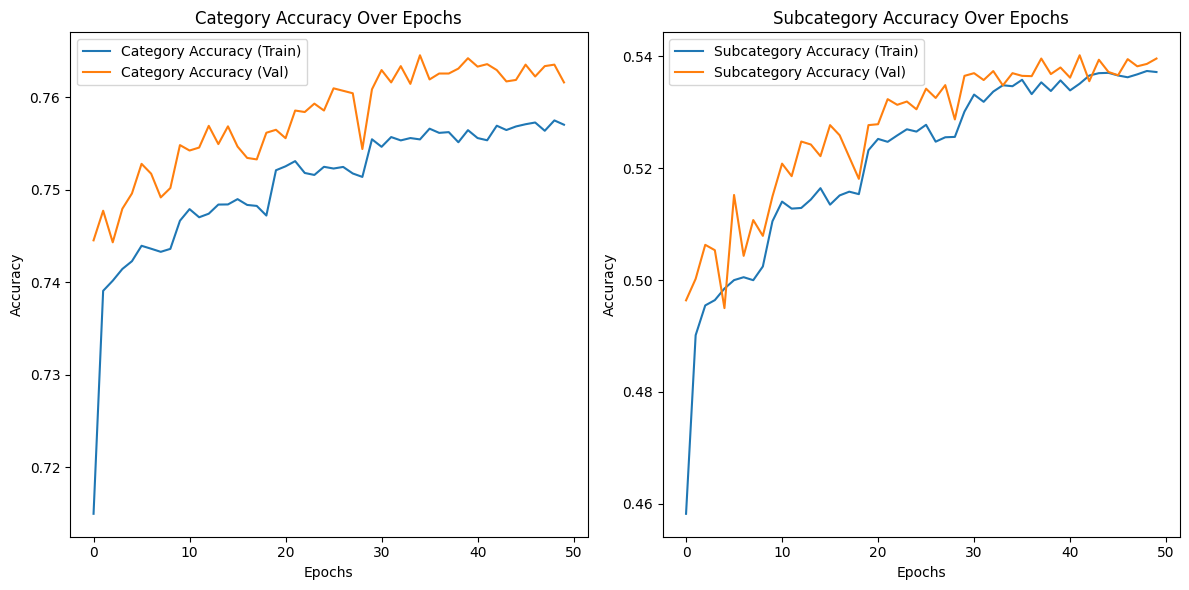

976/976 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of labels (16).

<Figure size 1000x800 with 0 Axes>

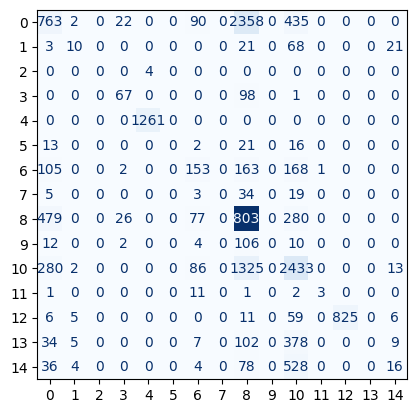

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Training history visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['category_output_accuracy'], label='Category Accuracy (Train)')
plt.plot(history.history['val_category_output_accuracy'], label='Category Accuracy (Val)')
plt.title('Category Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['subcategory_output_accuracy'], label='Subcategory Accuracy (Train)')
plt.plot(history.history['val_subcategory_output_accuracy'], label='Subcategory Accuracy (Val)')
plt.title('Subcategory Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Get predictions and probabilities for test data
y_cat_pred, y_sub_pred = model.predict(X_test)
y_cat_pred_classes = np.argmax(y_cat_pred, axis=1)
y_sub_pred_classes = np.argmax(y_sub_pred, axis=1)

# Confusion Matrix for categories
category_cm = confusion_matrix(y_cat_test, y_cat_pred_classes)
category_cm_display = ConfusionMatrixDisplay(confusion_matrix=category_cm, display_labels=category_encoder.classes_)
plt.figure(figsize=(10, 8))
category_cm_display.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
plt.title("Category Confusion Matrix")
plt.show()

# Confusion Matrix for subcategories
subcategory_cm = confusion_matrix(y_sub_test, y_sub_pred_classes)
subcategory_cm_display = ConfusionMatrixDisplay(confusion_matrix=subcategory_cm, display_labels=subcategory_encoder.classes_)
plt.figure(figsize=(10, 8))
subcategory_cm_display.plot(cmap='Greens', xticks_rotation='vertical', colorbar=False)
plt.title("Subcategory Confusion Matrix")
plt.show()


<Figure size 1000x800 with 0 Axes>

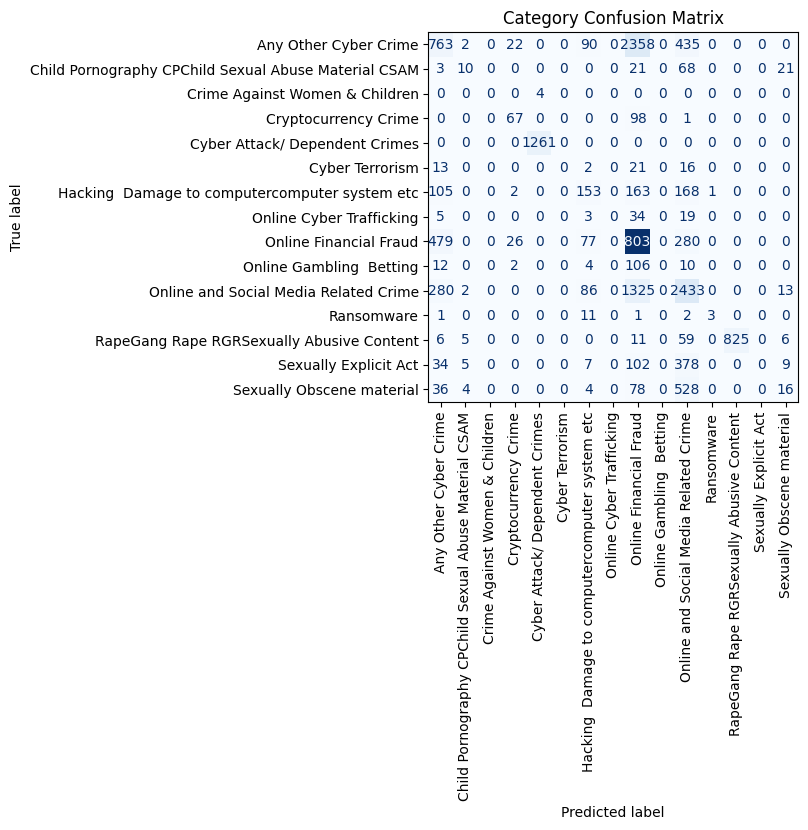

<Figure size 1000x800 with 0 Axes>

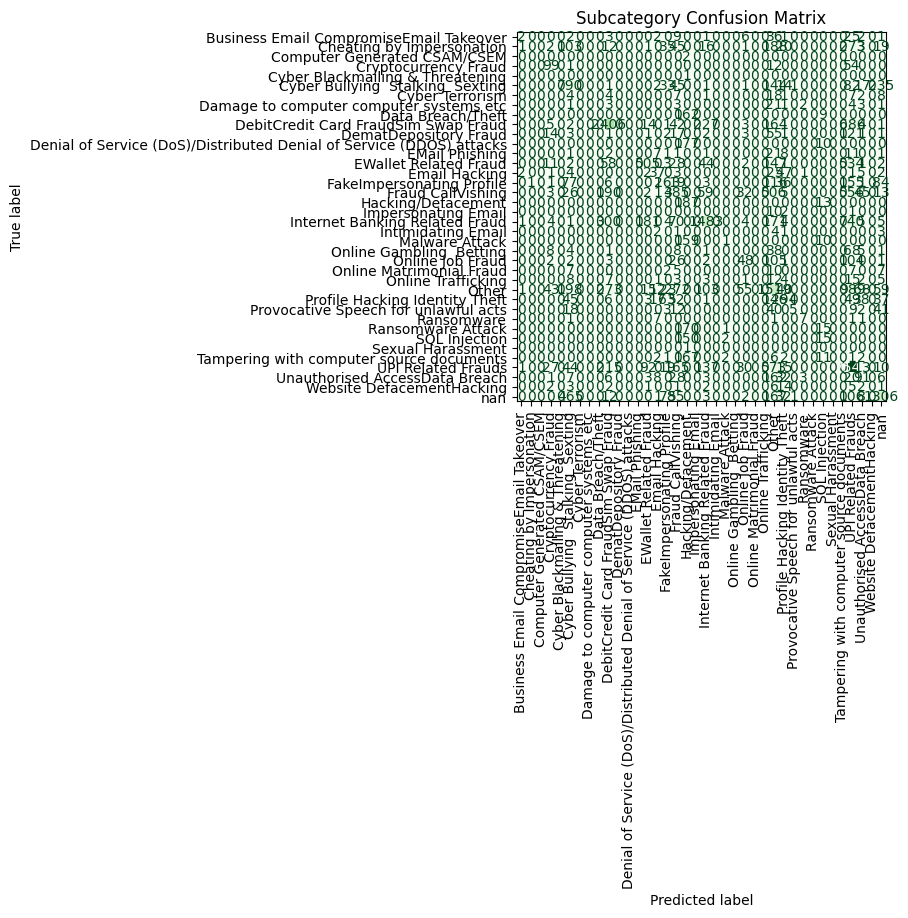

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get unique labels from the test data
unique_cat_labels = np.unique(y_cat_test)
unique_sub_labels = np.unique(y_sub_test)

# Confusion Matrix for categories
category_cm = confusion_matrix(y_cat_test, y_cat_pred_classes, labels=unique_cat_labels)
category_cm_display = ConfusionMatrixDisplay(confusion_matrix=category_cm, display_labels=category_encoder.inverse_transform(unique_cat_labels))
plt.figure(figsize=(10, 8))
category_cm_display.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
plt.title("Category Confusion Matrix")
plt.show()

# Confusion Matrix for subcategories
subcategory_cm = confusion_matrix(y_sub_test, y_sub_pred_classes, labels=unique_sub_labels)
subcategory_cm_display = ConfusionMatrixDisplay(confusion_matrix=subcategory_cm, display_labels=subcategory_encoder.inverse_transform(unique_sub_labels))
plt.figure(figsize=(10, 8))
subcategory_cm_display.plot(cmap='Greens', xticks_rotation='vertical', colorbar=False)
plt.title("Subcategory Confusion Matrix")
plt.show()


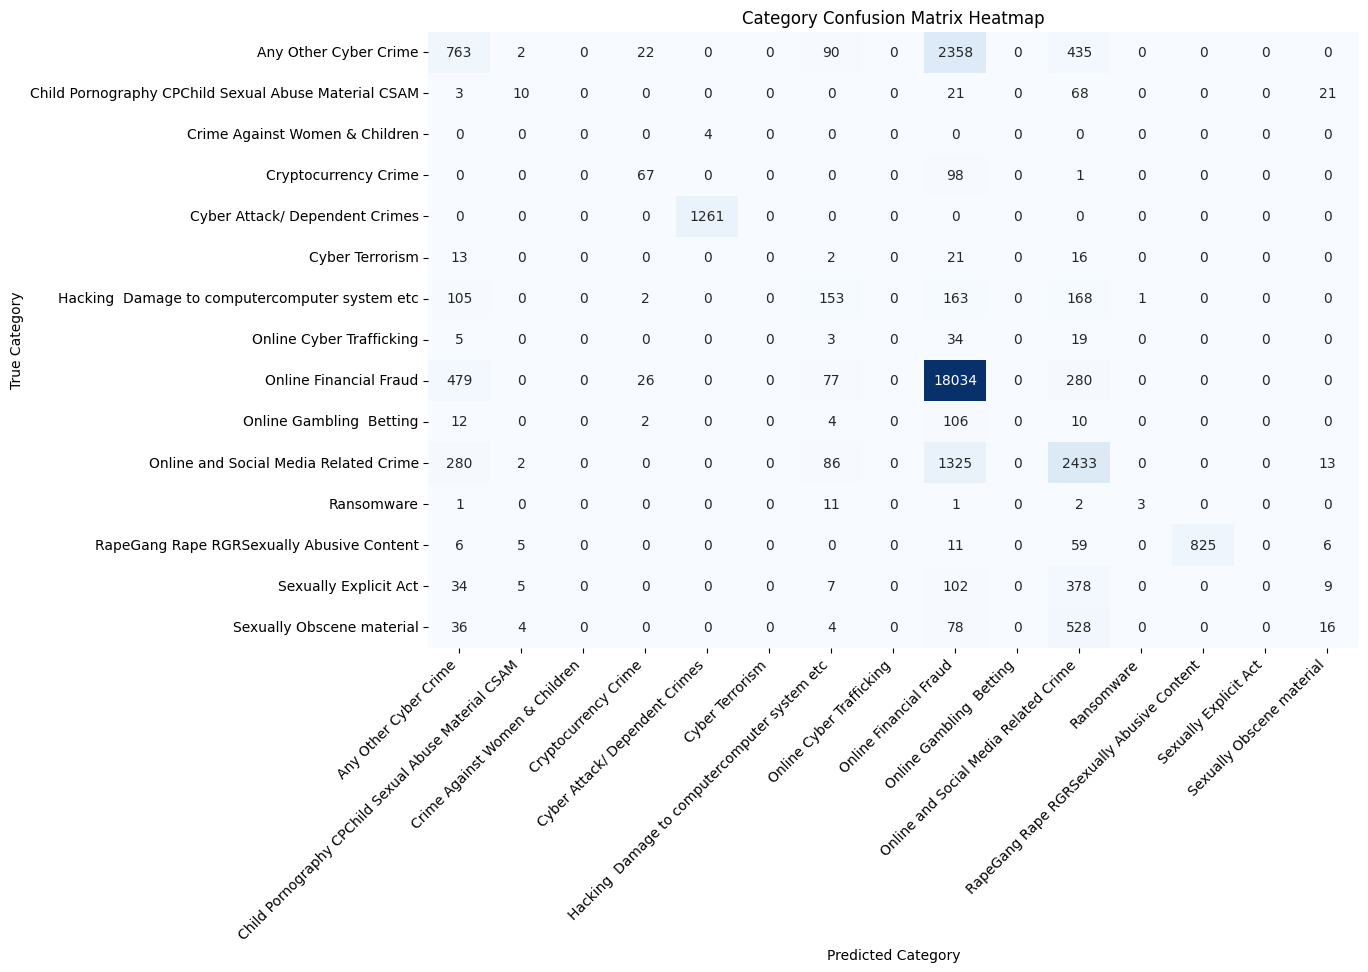

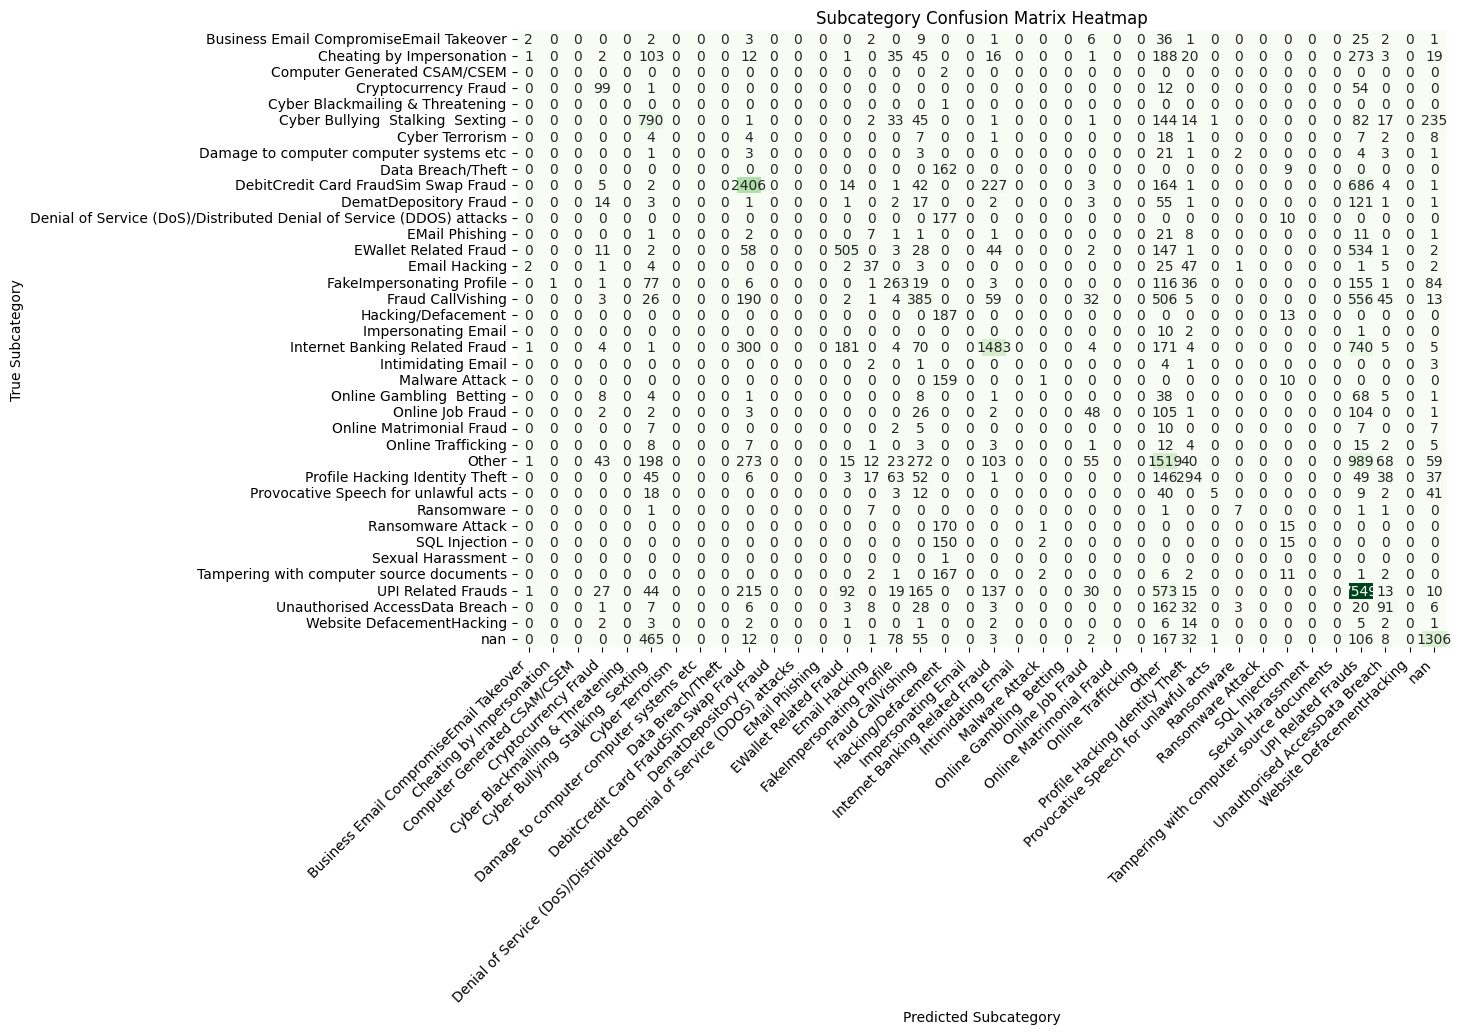

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Get unique labels from the test data
unique_cat_labels = np.unique(y_cat_test)
unique_sub_labels = np.unique(y_sub_test)

# Confusion Matrix for Categories
category_cm = confusion_matrix(y_cat_test, y_cat_pred_classes, labels=unique_cat_labels)
category_labels = category_encoder.inverse_transform(unique_cat_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(category_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_labels, yticklabels=category_labels, cbar=False)
plt.title("Category Confusion Matrix Heatmap")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Confusion Matrix for Subcategories
subcategory_cm = confusion_matrix(y_sub_test, y_sub_pred_classes, labels=unique_sub_labels)
subcategory_labels = subcategory_encoder.inverse_transform(unique_sub_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(subcategory_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=subcategory_labels, yticklabels=subcategory_labels, cbar=False)
plt.title("Subcategory Confusion Matrix Heatmap")
plt.xlabel("Predicted Subcategory")
plt.ylabel("True Subcategory")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


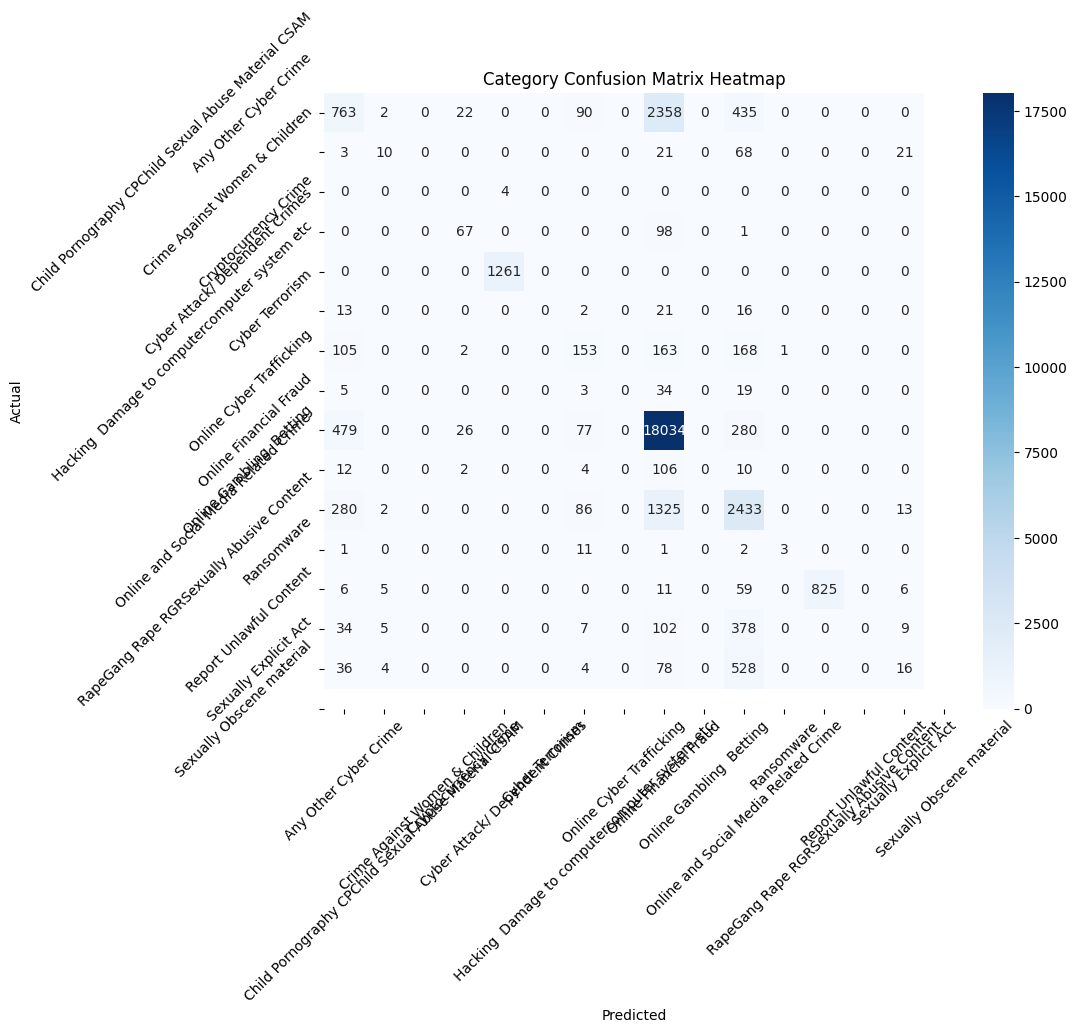

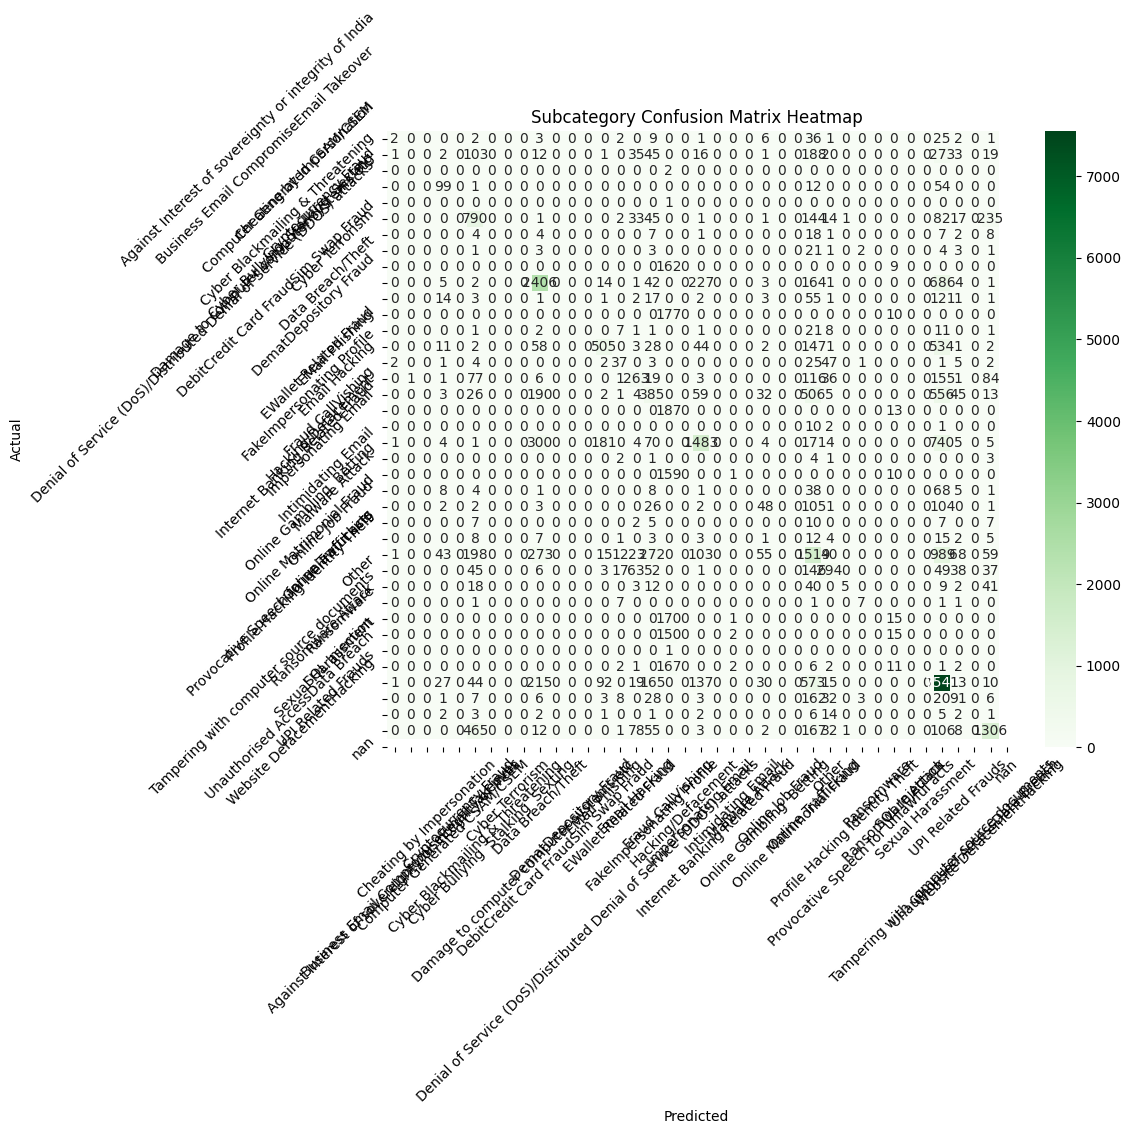

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix for categories
category_cm = confusion_matrix(y_cat_test, y_cat_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(category_cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.title("Category Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Confusion Matrix for subcategories
subcategory_cm = confusion_matrix(y_sub_test, y_sub_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(subcategory_cm, annot=True, fmt='d', cmap='Greens', xticklabels=subcategory_encoder.classes_, yticklabels=subcategory_encoder.classes_)
plt.title("Subcategory Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
